In [1]:
"""this notebook heavily refers to the post https://machinelearningmastery.com/develop-word-embeddings-python-gensim/"""

'this notebook heavily refers to the post https://machinelearningmastery.com/develop-word-embeddings-python-gensim/'

In [2]:
import nltk
#nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#for Stemming
from nltk.stem.snowball import DanishStemmer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:972: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\nmf.py:1186: DeprecationWarning: invalid escape sequence \s
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


In [3]:
import os,sys
parentPath = os.path.join(os.path.dirname(os.getcwd()),"tools")
sys.path.insert(0, parentPath)
from scripts_py import preprocessing as pre

yo uare sadfsaffsa		fsad


In [4]:
import codecs
def creat_file_list(author_name):
    file_list=['non']
    cwd=os.getcwd()
    parent_path = os.path.dirname(cwd)
    des_pos=os.path.join(parent_path,"ADL","metadata","metadata_adl.csv")
    fh=codecs.open(des_pos,'r','utf-8')
    for line in fh.readlines():
        L=line.split(",")
        if(re.search(author_name,L[1])):
            temp_string=L[0]+".txt"
            file_list.append(temp_string)
    return file_list[1:]

#### Prepare stopwords

In [5]:
# NLTK Stop words 
# TODO change to our own stop words list
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')
stop_words.extend(['paa','ved','saa','den'])

#### Select author here

In [6]:
author = "Grundtvig"
articles = creat_file_list(author)
articles[1:10]

['grundtvig09val_workid64460.txt',
 'grundtvig11val_workid71363.txt',
 'grundtvig11val_workid77740.txt',
 'grundtvig11val_workid148916.txt',
 'grundtvig11val_workid120113.txt',
 'grundtvig11val_workid109473.txt',
 'grundtvig11val_workid99472.txt',
 'grundtvig12val_workid55795.txt',
 'grundtvig12val_workid94218.txt']

#### Read in articles

In [7]:
data = list()
"""add any articles as you like if you want to analyze specific articles"""
#articles = ["aare01val_workid69870.txt","aakjaer01val_workid55565.txt","aakjaer01val_workid55662.txt"
#            ,"aakjaer01val_workid55881.txt"]
"""following line process all the articles but this may require huge computing power"""
#articles=os.listdir(os.path.join(os.path.dirname(os.getcwd()),"ADL","plain"))
dataTest = list()
for ele in articles:
    article = os.path.join(os.path.dirname(os.getcwd()),"ADL","plain",ele)
    with open(article, encoding ="utf-8") as f:
        lines = f.readlines()
        dataTest.append(lines)
    data.append( ' '.join(lines))

In [8]:
data =  [item for items in dataTest for item in items]

#### Preprocessing

In [9]:
nalpha_content = [pre.re_nalpha(ele) for ele in data]
tokenized_content = [pre.tokenizer(ele) for ele in nalpha_content]

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [11]:
def stemmer(wordList):
    """stemming the words for later processing"""
    stemmer = DanishStemmer()
    return [[stemmer.stem(tempWord) for tempWord in sentence] for sentence in wordList  ]

In [12]:
non_stop = remove_stopwords(tokenized_content)

In [13]:
stemmed_data = stemmer(non_stop)

In [14]:
stemmed_data[1:5]

[['barn',
  'glæd',
  'vilog',
  'sjung',
  'høieidag',
  'ei',
  'sorg',
  'jord',
  'tilsom',
  'kan',
  'sjæl',
  'nedbøieidag',
  'fat',
  'betl',
  'rig',
  'paradis',
  'jord',
  'miggud',
  'engl',
  'kvædeidag',
  'frels',
  'fødidag',
  'al',
  'jord',
  'sorg',
  'dødog',
  'født',
  'al',
  'jord',
  'glædeei',
  'synd',
  'død',
  'verd',
  'meerm',
  'knug',
  'kysejeg',
  'naad',
  'sol',
  'oprund',
  'seerog',
  'evig',
  'lyse',
  'kong',
  'idag',
  'fød',
  'lid',
  'barn',
  'mod',
  'skiødal',
  'verd',
  'nød',
  'betvingerhan',
  'rig',
  'himmel',
  'jord'],
 ['ingeman', 'julesang'],
 ['par',
  'kong',
  'evig',
  'tro',
  'svorog',
  'sjæl',
  'gav',
  'vingerflyv',
  'høit',
  'sjæl',
  'barnefroforlyst',
  'rigemed',
  'kiær',
  'haab',
  'trohan',
  'ord',
  'aldr',
  'svigei',
  'klud',
  'svøbt',
  'kryb',
  'lagtd',
  'barn',
  'storm',
  'magtog',
  'hav',
  'bølgerei',
  'jord',
  'ei'],
 ['luft']]

#### Training the model

In [15]:
from gensim.models import Word2Vec

In [16]:
model = Word2Vec(non_stop, min_count=1)
#if you have some pre-trained model using the following line
#new_model = Word2Vec.load('model.bin')

#### Summary of the model 

In [17]:
#summary of the model
print(model)

Word2Vec(vocab=157533, size=100, alpha=0.025)


In [18]:
#summary of the words in the model
all_words = list(model.wv.vocab)
print(all_words[:10])

['no', 'barn', 'glæde', 'vilog', 'sjunge', 'høieidag', 'ei', 'sorg', 'jord', 'tilsom']


#### Visual summary of the model

In [19]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [20]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

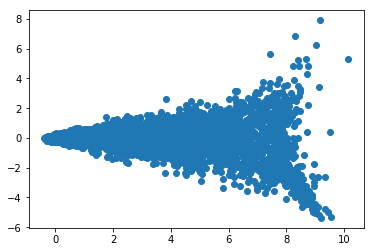

In [21]:
pyplot.scatter(result[:, 0], result[:, 1])

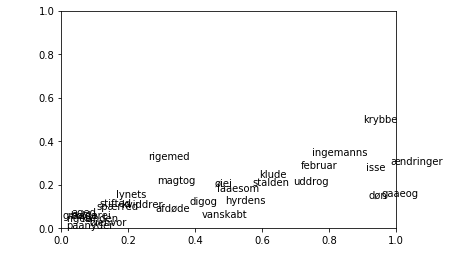

In [22]:
#select the words as your like, here we only selet first 400 words
words = all_words[:400]
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

### Play with the model

##### Find the most similar words in the model

In [23]:

#specify how many words you want to see
num_top = 10
#the word you want to find
positive_word = ['barn','lykkelig']
#the word you don't want to find
negative_word = ['mand']
#the resulting word = barn + lykkelig - mand
result = model.most_similar(positive= positive_word, 
                            negative = negative_word,topn=num_top)
print(result)

[('gienfødes', 0.983723521232605), ('aabenbarelse', 0.9837073087692261), ('hørelse', 0.9832383394241333), ('jordfor', 0.9831761121749878), ('sangfra', 0.9830288887023926), ('kvindens', 0.9825624227523804), ('givetdet', 0.982508659362793), ('klapper', 0.9822804927825928), ('almagts', 0.9821160435676575), ('sandfærdige', 0.982073962688446)]


#### Get the similarity between two words

In [24]:
#compare the similarity between two words
word1 = 'konge'
word2 = 'dronning'
model.wv.similarity(w1=word1,w2=word2) 
#the bigger the score the more similar this two words are

0.97660240729926573

#### Save the model

In [25]:
# save model，using any name you wound like to
model.save('cachedModel/model.bin')